# ARC AGI with Llama 3.2 1B - Test-time Fine-tuning

## 1. Load and re-format the raw data

Load the ARC tasks. We split tasks containing more than one test input into separate tasks to make the pipeline easier.

Data uploads:
1. If you're running this on a remote GPU and have uploaded this notebook, you'll need to upload the raw arc json files as well.
2. To run on a smaller split, also upload `mit-easy.json`.

In [1]:
!python -m pip install --upgrade pip -q
!pip install uv -q

!uv pip install huggingface_hub -qU
from huggingface_hub import login
login()

In [ ]:
!uv pip install pandas datasets tensorboard matplotlib numpy -qU --system

In [2]:
# Helper if we're reloading the model

import torch, gc, inspect, sys

def clear_old_model_refs():
    """
    Delete `model` and `tokenizer` (if they exist) from the caller’s
    local *and* global scope, then garbage-collect and free GPU cache.
    """

    # ── figure out the caller’s frame ────────────────────────────
    frm = inspect.currentframe().f_back
    caller_locals  = frm.f_locals
    caller_globals = frm.f_globals

    for var in ("model", "tokenizer"):
        if var in caller_locals:
            try:
                del caller_locals[var]
                if var in sys.modules:   # rarely needed
                    del sys.modules[var]
                print(f"deleted local  {var}")
            except Exception as e:
                print(f"could not delete local {var}: {e}")

        if var in caller_globals:
            try:
                del caller_globals[var]
                print(f"deleted global {var}")
            except Exception as e:
                print(f"could not delete global {var}: {e}")

    # ── Python & CUDA cleanup ───────────────────────────────────
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU cache cleared.")


In [3]:
"""
arc_dataset_loader.py
====================
Utility helpers to load the ARC‑AGI training and evaluation splits as
Hugging Face `datasets.Dataset` objects.

Features
--------
* **Single public entry point** – `get_arc_datasets` returns two datasets
  (`arc_train`, `arc_eval`).
* **Optional sub‑sampling** of either split via a JSON file containing a
  list of problem IDs (e.g. those from `mit-easy.json`).
* Correctly **fans‑out tasks that contain multiple test IO pairs** so that
  every row has exactly one test case – exactly mirroring the logic used
  during scoring.
* **Lazy file resolution** – only the files required for each split are
  touched; just point `data_dir` at the location that holds the
  `arc-agi_*` JSON files.

Example
~~~~~~~
>>> from arc_dataset_loader import get_arc_datasets
>>> train_ds, eval_ds = get_arc_datasets(
...     data_dir="/path/to/data",
...     eval_subsample_json="mit-easy.json",
... )
>>> print(len(train_ds), len(eval_ds))

The returned objects are standard `datasets.Dataset` instances and can be
used in any HF preprocessing / dataloader pipeline.
"""
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import pandas as pd
from datasets import Dataset

__all__ = [
    "get_arc_datasets",
]

###############################################################################
# Internal helpers
###############################################################################

def _split_dictionary(data: Dict[str, Dict]) -> Tuple[Dict[str, Dict], List[str]]:
    """Split tasks that have *multiple* test IO pairs into separate entries.

    Each new key is suffixed with an integer index (e.g. `"abcd1234_1"`).

    Returns the revamped dictionary **and** a list with the names of the
    expanded tasks (useful for debugging).
    """
    result: Dict[str, Dict] = {}
    split_files: List[str] = []

    for key, value in data.items():
        test_list = value.get("test", [])
        train_list = value.get("train", [])

        if len(test_list) > 1:
            for idx, test_item in enumerate(test_list):
                new_key = f"{key}_{idx}"
                result[new_key] = {"test": [test_item], "train": train_list}
                split_files.append(new_key)
        else:
            # untouched – already a single‑case task
            result[key] = value

    return result, split_files


def _build_dataframe(
    *,
    challenges: Dict[str, Dict],
    solutions: Optional[Dict[str, List]] = None,
) -> pd.DataFrame:
    """Construct the canonical DataFrame used for both splits."""
    data_rows: List[Dict] = []

    for file_name, grids in challenges.items():
        train_grids = grids.get("train", [])
        test_inputs = grids.get("test", [])

        # If solutions are provided (train and evaluation splits) we harvest
        # the correct test outputs. When we created `challenges` we already
        # fan‑out multi‑case tasks, so every entry has exactly one test item.
        if solutions is not None:
            parts = file_name.split("_")
            base_key, test_idx = parts[0], int(parts[1] if len(parts) > 1 else 0)
            correct_outputs = solutions.get(base_key, [])
            # Guard: some evaluation sets may intentionally omit solutions
            if test_idx >= len(correct_outputs):
                raise ValueError(
                    f"No solution available for {file_name} (idx {test_idx})."
                )
            test_output = [{"output": correct_outputs[test_idx]}]
        else:
            test_output = []  # unknown at inference time

        combined_test = (
            [
                {
                    "input": test_inputs[0]["input"],
                    "output": test_output[0]["output"],
                }
            ]
            if test_output
            else test_inputs
        )

        data_rows.append(
            {
                "file_name": file_name,
                "train": train_grids,
                "test_input": test_inputs,
                "test_output": test_output,
                "test": combined_test,
            }
        )

    return pd.DataFrame(data_rows)


def _apply_subsample(df: pd.DataFrame, subsample_file: Path | None) -> pd.DataFrame:
    """Optionally filter rows by problem IDs listed in *subsample_file*."""
    if subsample_file is None:
        return df

    with subsample_file.open() as fp:
        ids = [line.strip() for line in json.load(fp)]  # expects a JSON list

    # The DataFrame rows may be *split* versions – we harvest the *root* ID
    return df[df["file_name"].str.extract(r"^([a-f0-9]+)")[0].isin(ids)]


###############################################################################
# Public API
###############################################################################

def get_arc_datasets(
    *,
    data_dir: str | Path = ".",  # directory holding the arc‑agi_*.json files
    eval_subsample_json: str | Path | None = None,
    train_subsample_json: str | Path | None = None,
) -> Tuple[Dataset, Dataset]:
    """Return `(arc_train, arc_eval)` as `datasets.Dataset` objects.

    Parameters
    ----------
    data_dir:
        Base directory containing the official ARC‑AGI JSON files (training,
        evaluation). Defaults to the current working directory.

    eval_subsample_json / train_subsample_json:
        Optional path(s) to a JSON file with a list of problem IDs that
        should be kept. When *None* the full split is used.

    Notes
    -----
    *We purposely do not expose the private‑test split here – that file set
    lacks ground‑truth solutions and must be handled separately.*
    """
    data_dir = Path(data_dir)

    ###############  TRAIN SPLIT  ###########################################
    with (data_dir / "arc-agi_training_challenges.json").open() as fp:
        train_challenges = json.load(fp)
    train_challenges, _ = _split_dictionary(train_challenges)

    with (data_dir / "arc-agi_training_solutions.json").open() as fp:
        train_solutions = json.load(fp)

    train_df = _build_dataframe(
        challenges=train_challenges,
        solutions=train_solutions,
    )
    train_df = _apply_subsample(train_df, Path(train_subsample_json) if train_subsample_json else None)

    ###############  EVAL SPLIT  ############################################
    with (data_dir / "arc-agi_evaluation_challenges.json").open() as fp:
        eval_challenges = json.load(fp)
    eval_challenges, _ = _split_dictionary(eval_challenges)

    # Evaluation split *does* ship with solutions – they just aren’t public on
    # Kaggle. Adjust the path below if you keep them elsewhere.
    eval_sol_path = data_dir / "arc-agi_evaluation_solutions.json"
    if eval_sol_path.exists():
        with eval_sol_path.open() as fp:
            eval_solutions = json.load(fp)
    else:
        eval_solutions = None  # e.g. you’re working on the competition

    eval_df = _build_dataframe(
        challenges=eval_challenges,
        solutions=eval_solutions,
    )
    eval_df = _apply_subsample(eval_df, Path(eval_subsample_json) if eval_subsample_json else None)

    ###############  CONVERT → HF DATASET  ###################################
    arc_train = Dataset.from_pandas(train_df.reset_index(drop=True))
    arc_eval = Dataset.from_pandas(eval_df.reset_index(drop=True))

    return arc_train, arc_eval

In [4]:
arc_train, arc_eval = get_arc_datasets(
        # data_dir=args.data_dir, # comment out to use default
        eval_subsample_json="mit-easy.json", # comment out to use default of none
        # train_subsample_json=args.train_subsample, # comment out to use default of none
    )

print(
    f"Loaded {len(arc_train):,} training tasks and {len(arc_eval):,} evaluation tasks."
)

Loaded 416 training tasks and 20 evaluation tasks.


In [5]:
print(arc_train[0])

{'file_name': '007bbfb7', 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0, 0]]}, {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 2], [2, 0, 2, 0, 0, 0, 2, 0, 2]]}, {'input

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# -------------------------------------------------------------------
# ARC-style palette (feel free to replace with your own)
# 0-9 integers → 10 RGB triples
ARC_PALETTE = np.array([
    [  0,   0,   0],   # 0 black
    [255,   0,   0],   # 1 red
    [  0, 255,   0],   # 2 green
    [255, 255,   0],   # 3 yellow
    [  0,   0, 255],   # 4 blue
    [255,   0, 255],   # 5 magenta
    [  0, 255, 255],   # 6 cyan
    [255, 255, 255],   # 7 white
    [128, 128, 128],   # 8 gray
    [128,   0,   0],   # 9 dark-red (example)
], dtype=np.uint8)
ARC_CMAP = ListedColormap(ARC_PALETTE / 255.0, name='arc')

# -------------------------------------------------------------------
def plot_grid(grid, title='', ax=None, cmap=ARC_CMAP):
    """
    Display an integer-labelled colour grid on the given Matplotlib axis.

    Parameters
    ----------
    grid  : 2-D ndarray of ints 0-9
    title : str
    ax    : matplotlib.axes.Axes or None
    cmap  : matplotlib.colors.Colormap
    """
    if ax is None:
        ax = plt.gca()

    ax.imshow(grid, interpolation='nearest', cmap=cmap, vmin=0, vmax=9)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

Selecting inner index 0


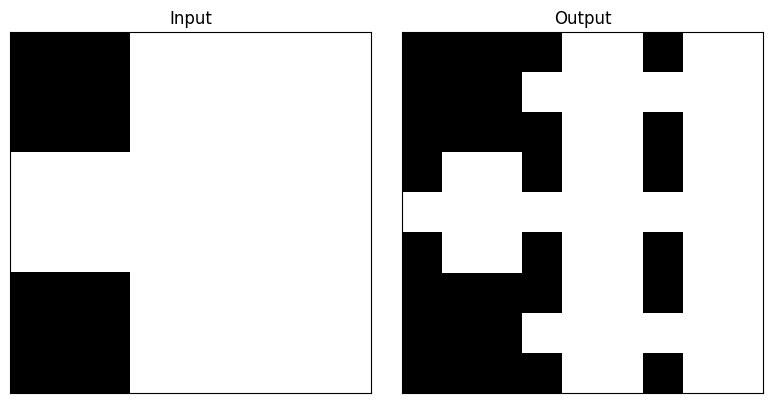

In [7]:
challenge_index = 0
challenge_split='train' # train or test
split_index=0
type='input' # input or output

challenge = arc_train[challenge_index]
print(f"Selecting inner index {split_index}")

challenge_split = challenge[challenge_split]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_grid(challenge_split[split_index]['input'],  'Input',  ax=axes[0])
plot_grid(challenge_split[split_index]['output'], 'Output', ax=axes[1])
plt.tight_layout()
plt.show()

grid = challenge_split[split_index][type]

## 2. Create Evaluation and Fine-tuning Datasets
- The evaluation dataset is for running an evaluation, not training. Use the ARC `eval` dataset here.
- The fine-tuning dataset is for running a fine-tuning. You have a few options here and could use:
    1. a synthetic ReARC dataset,
    2. the ARC "train" dataset,
    3. the ARC "eval" dataset, but with "omit_test" set to True so that test examples are not included. If you do this, you are doing test-time training (that is not task-specific).

The dataset preparations functions will create a hf style dataset of messages, with a user message containing the first n-1 of n examples (inputs plus outputs) as train examples and the nth train input as the test example, and with an assistant message using the nth train output.

When generating a fine-tuning dataset, you can optionally:
- Expand that dataset via shuffling the order of examples.
- Expand that dataset via colour shuffling.
- Expand that dataset via rotations.

In [8]:
preprompt="" # There is no point in providing a complicated pre-prompt
# "Given the following training examples with their input-output pairs, "
# "predict the output for the test input based on the same "
# "transformation rules:\n\n"

In [9]:
from datasets import Dataset
import numpy as np

def prepare_evaluation_dataset(input_dataset, drop_first_train=False):
    """
    Prepares evaluation datasets from the input dataset.
    
    Args:
        input_dataset: A dataset containing 'file_name', 'train', and 'test' splits.
                       Each 'train' entry contains 'input' and 'output' examples, and
                       'test' contains 'input' and 'output' for evaluation.
        drop_first_train (bool): Whether to drop the first training example. Defaults to False. Allows the training tasks to be shortened to shorten the context length.
    
    Returns:
        - evaluation_dataset: Dataset formatted for evaluation.
    """
    
    # Evaluation dataset preparation
    evaluation_data = []
    for challenge in input_dataset:
        file_name = challenge['file_name']
        train_examples = challenge['train']
        test_example = challenge['test'][0]  # Use the first test example
        
        # Use all training examples as context, optionally dropping the first one
        start_index = 1 if drop_first_train else 0
        user_message_content = (
            preprompt
        )
        for i, example in enumerate(train_examples[start_index:]):  # Include all training examples
            user_message_content += (
                f"Input:\n{np.array(example['input'])}\n"
                f"Output:\n{np.array(example['output'])}\n\n"
            )
        # Use the first test example's input as the test input
        test_input = test_example['input']
        user_message_content += f"Test Input:\n{np.array(test_input)}\nTest Output:\n"
        user_message = {"role": "user", "content": user_message_content}
        assistant_message = {
            "role": "assistant",
            "content": f"{np.array(test_example['output'])}\n\n"
        }

        evaluation_data.append({
            "file_name": file_name,
            "messages": [user_message, assistant_message]
        })
    
    # Create HuggingFace Datasets
    evaluation_dataset = Dataset.from_list(evaluation_data)
    
    return evaluation_dataset

In [10]:
from datasets import Dataset
import numpy as np
from copy import deepcopy
from typing import List, Dict, Iterable, Union

def prepare_fine_tuning_dataset(
    input_dataset: Iterable[Dict],
    *,
    add_shuffled: Union[int, bool] = 0,   # 0/False → none, True → unlimited
    add_rotations: bool = False,
    add_mirrors: bool = False,
    omit_test: bool = True,
    apply_color_swaps: bool = False,
    num_color_swaps: int = 2,
    seed: int = 42,
) -> Dataset:
    """
    Build a HuggingFace `Dataset` for ARC fine-tuning where **every row is a
    multi-example chat prompt/response**:

        • Context  = all but one example (train examples only, or train+test
                     depending on `omit_test`)
        • Query    = that held-out example (“Test Input …”)
        • Answer   = its output grid

    Parameters
    ----------
    add_shuffled   int  – how many *extra* shuffled rows to add *per task*.
                         0/False → none.  True → as many permutations as exist.
                         For each such row we (a) choose a different held-out
                         pair, (b) randomly shuffle the context order.
    add_rotations / add_mirrors / apply_color_swaps
                   If `True`, duplicate every (possibly shuffled) row with
                   rotated / mirrored / colour-swapped variants.
    omit_test      If False ➜ held-out pair is taken from `test`;  
                   If True  ➜ held-out pair is taken from `train`.
    """
    rng = np.random.default_rng(seed)
    rows: List[Dict] = []

    # ───────────────────────── helper transforms ──────────────────────────── #
    def rotate_grid(grid, angle: int):
        if angle not in (90, 180, 270):
            return grid
        return np.rot90(np.array(grid), k=angle // 90).tolist()

    def mirror_grid(grid, direction: str):
        arr = np.array(grid)
        if direction == "horizontal":
            return np.fliplr(arr).tolist()
        if direction == "vertical":
            return np.flipud(arr).tolist()
        return grid

    def apply_mapping(grid, mapping_arr: np.ndarray):
        return mapping_arr[np.array(grid)].tolist()

    # ────────────────────── build ONE prompt/response row ─────────────────── #
    def make_row(file_tag: str,
                 ctx_list: List[Dict],
                 q_pair: Dict) -> Dict:
        prompt = preprompt
        for ex in ctx_list:
            prompt += (
                f"Input:\n{np.array(ex['input'])}\n"
                f"Output:\n{np.array(ex['output'])}\n\n"
            )
        prompt += f"Test Input:\n{np.array(q_pair['input'])}\nTest Output:\n"

        return {
            "file_name": file_tag,
            "messages": [
                {"role": "user",      "content": prompt},
                {"role": "assistant", "content": f"{np.array(q_pair['output'])}\n\n"},
            ],
        }

    # ────────────────────────── per task processing ───────────────────────── #
    def build_rows_for_task(file_name: str,
                            train_ex: List[Dict],
                            test_ex: List[Dict]) -> List[Dict]:
        """
        Build one or more **multi-example** chat rows for a single ARC task.
    
        • If `omit_test=False` the pool of possible held-out pairs is
          `test_ex + train_ex` (test examples first so the “base” row matches
          evaluation).  
        • If `omit_test=True`  the pool is `train_ex` only; every test example
          is ignored.
    
        `add_shuffled` (int or bool) controls how many *extra* rows (beyond the
        base row) are generated, each time choosing a different held-out pair
        and shuffling the order of the remaining context examples.
        """
        task_rows: List[Dict] = []
    
        # ---------- 1 – assemble pool of held-out candidates ------------------ #
        if omit_test or not test_ex:                     # ignore test examples
            if len(train_ex) < 2:                        # need ≥2 to hold one out
                return []                                # nothing we can do
            candidates = train_ex                        # held-out comes from train
        else:                                            # may hold out test *or* train
            candidates = test_ex + train_ex              # test first → base row identical
    
        # ---------- 2 – decide how many *extra* rows we want ------------------ #
        max_extra = len(candidates) - 1                  # cannot exceed pool size
        if add_shuffled is True:                         # unlimited
            want = max_extra
        else:
            want = int(add_shuffled) if add_shuffled else 0
            want = min(want, max_extra)
    
        # ---------- 3 – choose the held-out examples -------------------------- #
        chosen_candidates = [candidates[0]]              # base row
        remaining = candidates[1:]
        if want:
            rng.shuffle(remaining)
            chosen_candidates += remaining[:want]
    
        # ---------- 4 – build one row for each chosen candidate --------------- #
        for idx, held_out in enumerate(chosen_candidates):
            # context = all train examples except the held-out one (if it’s a train ex)
            #         = all train examples               (if held-out is a test ex)
            if held_out in train_ex:
                context = [ex for ex in train_ex if ex is not held_out]
            else:
                context = train_ex
    
            # shuffle context order only in the *extra* rows
            ctx_order = (rng.permutation(context).tolist()
                         if (add_shuffled and idx > 0)
                         else context)
    
            base_tag       = "" if idx == 0 else f"_shuffle{idx}"
            base_file_name = f"{file_name}{base_tag}"
    
            # -- 4a. original orientation -------------------------------------- #
            task_rows.append(make_row(base_file_name, ctx_order, held_out))
    
            # -- 4b. rotations -------------------------------------------------- #
            if add_rotations:
                for angle in (90, 180, 270):
                    ctx_rot = [{"input":  rotate_grid(ex["input"],  angle),
                                "output": rotate_grid(ex["output"], angle)}
                               for ex in ctx_order]
                    q_rot   = {"input":  rotate_grid(held_out["input"],  angle),
                               "output": rotate_grid(held_out["output"], angle)}
                    tag = f"{base_file_name}_rot{angle}"
                    task_rows.append(make_row(tag, ctx_rot, q_rot))
    
            # -- 4c. mirrors ---------------------------------------------------- #
            if add_mirrors:
                for direction in ("horizontal", "vertical"):
                    ctx_mir = [{"input":  mirror_grid(ex["input"],  direction),
                                "output": mirror_grid(ex["output"], direction)}
                               for ex in ctx_order]
                    q_mir   = {"input":  mirror_grid(held_out["input"],  direction),
                               "output": mirror_grid(held_out["output"], direction)}
                    tag = f"{base_file_name}_{direction}"
                    task_rows.append(make_row(tag, ctx_mir, q_mir))
    
        return task_rows

    # ─────────────────────────── master pipeline ──────────────────────────── #
    for challenge in input_dataset:
        file_name  = challenge["file_name"]
        base_train = challenge["train"]
        base_test  = challenge.get("test", [])

        # (1) original rows (plus rot/mirror)
        rows.extend(build_rows_for_task(file_name, base_train, base_test))

        # (2) global colour-swap augmentations
        if apply_color_swaps and num_color_swaps > 0:
            used_cols = {
                c
                for ex in base_train + base_test
                for grid in (ex["input"], ex["output"])
                for row in grid
                for c in row
            }

            swaps_done = 0
            while swaps_done < num_color_swaps:
                perm = rng.permutation(10)
                if all(perm[c] == c for c in used_cols):
                    continue                          # nothing actually swapped

                map_arr = perm
                train_swapped = [
                    {"input":  apply_mapping(ex["input"],  map_arr),
                     "output": apply_mapping(ex["output"], map_arr)}
                    for ex in deepcopy(base_train)
                ]
                test_swapped = [
                    {"input":  apply_mapping(ex["input"],  map_arr),
                     "output": apply_mapping(ex["output"], map_arr)}
                    for ex in deepcopy(base_test)
                ]

                rows.extend(
                    build_rows_for_task(
                        f"{file_name}_swap{swaps_done+1}",
                        train_swapped,
                        test_swapped,
                    )
                )
                swaps_done += 1

    return Dataset.from_list(rows)

In [11]:
# Build the evaluation set (no augmentation, *with* test examples)
eval_dataset = prepare_evaluation_dataset(
    arc_eval,
)
print(eval_dataset)
print(eval_dataset[0])

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})
{'file_name': '00576224', 'messages': [{'content': 'Input:\n[[8 6]\n [6 4]]\nOutput:\n[[8 6 8 6 8 6]\n [6 4 6 4 6 4]\n [6 8 6 8 6 8]\n [4 6 4 6 4 6]\n [8 6 8 6 8 6]\n [6 4 6 4 6 4]]\n\nInput:\n[[7 9]\n [4 3]]\nOutput:\n[[7 9 7 9 7 9]\n [4 3 4 3 4 3]\n [9 7 9 7 9 7]\n [3 4 3 4 3 4]\n [7 9 7 9 7 9]\n [4 3 4 3 4 3]]\n\nTest Input:\n[[3 2]\n [7 8]]\nTest Output:\n', 'role': 'user'}, {'content': '[[3 2 3 2 3 2]\n [7 8 7 8 7 8]\n [2 3 2 3 2 3]\n [8 7 8 7 8 7]\n [3 2 3 2 3 2]\n [7 8 7 8 7 8]]\n\n', 'role': 'assistant'}]}


In [12]:
# Build the training set (lots of augmentation, no test examples)
fine_tuning_dataset = prepare_fine_tuning_dataset(
    arc_train, # or set to arc_eval with omit_test=True
    # arc_eval,
    omit_test=False,
    add_shuffled=1, #set to True for all permutations, or set to an integer for a max number of shuffles
    add_rotations=True, # applies to original rotation only
    add_mirrors=True, # applies to original examples only
    apply_color_swaps=True,
    num_color_swaps=1,
)

print(fine_tuning_dataset)
print(fine_tuning_dataset[0])

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 9984
})
{'file_name': '007bbfb7', 'messages': [{'content': 'Input:\n[[0 7 7]\n [7 7 7]\n [0 7 7]]\nOutput:\n[[0 0 0 0 7 7 0 7 7]\n [0 0 0 7 7 7 7 7 7]\n [0 0 0 0 7 7 0 7 7]\n [0 7 7 0 7 7 0 7 7]\n [7 7 7 7 7 7 7 7 7]\n [0 7 7 0 7 7 0 7 7]\n [0 0 0 0 7 7 0 7 7]\n [0 0 0 7 7 7 7 7 7]\n [0 0 0 0 7 7 0 7 7]]\n\nInput:\n[[4 0 4]\n [0 0 0]\n [0 4 0]]\nOutput:\n[[4 0 4 0 0 0 4 0 4]\n [0 0 0 0 0 0 0 0 0]\n [0 4 0 0 0 0 0 4 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 4 0 4 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 4 0 0 0 0]]\n\nInput:\n[[0 0 0]\n [0 0 2]\n [2 0 2]]\nOutput:\n[[0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 2]\n [0 0 0 0 0 0 2 0 2]\n [0 0 0 0 0 0 0 0 0]\n [0 0 2 0 0 0 0 0 2]\n [2 0 2 0 0 0 2 0 2]]\n\nInput:\n[[6 6 0]\n [6 0 0]\n [0 6 6]]\nOutput:\n[[6 6 0 6 6 0 0 0 0]\n [6 0 0 6 0 0 0 0 0]\n [0 6 6 0 6 6 0 0 0]\n [6 6 0 0 0 0 

In [13]:
print(fine_tuning_dataset[479])

{'file_name': '11852cab_swap1_shuffle1_vertical', 'messages': [{'content': 'Input:\n[[3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 7 3 3 3 3 3]\n [3 3 3 9 3 9 3 3 3 3]\n [3 3 7 3 6 3 7 3 3 3]\n [3 3 3 9 3 9 3 3 3 3]\n [3 3 6 3 7 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]]\nOutput:\n[[3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 6 3 7 3 6 3 3 3]\n [3 3 3 9 3 9 3 3 3 3]\n [3 3 7 3 6 3 7 3 3 3]\n [3 3 3 9 3 9 3 3 3 3]\n [3 3 6 3 7 3 6 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]]\n\nInput:\n[[3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 7 3 7 3 7 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 7 3 0 3 7 3 3]\n [3 3 3 3 8 3 3 3 3 3]\n [3 3 3 7 3 7 3 7 3 3]\n [3 3 3 3 3 3 3 3 3 3]]\nOutput:\n[[3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 3 3 3 3 3 3 3]\n [3 3 3 7 3 7 3 7 3 3]\n [3 3 3 3 8 3 8 3 3 3]\n [3 3 3 7 3 0 3 7 3 3

In [61]:
# Downsampling
import random

N = 1_000                      # how many examples you want
seed = 42                      # for reproducibility

# If you’re using a Hugging Face `datasets.Dataset`
if hasattr(fine_tuning_dataset, "shuffle"):
    fine_tuning_dataset = (
        fine_tuning_dataset
        .shuffle(seed=seed)            # randomise order once
        .select(range(min(N, len(fine_tuning_dataset))))  # take the first N rows
    )

# Fallback: if it’s a plain Python list / tuple
else:
    random.seed(seed)
    fine_tuning_dataset = random.sample(
        fine_tuning_dataset, 
        k=min(N, len(fine_tuning_dataset))
    )

print(f"Sampled {len(fine_tuning_dataset)} examples")
print(fine_tuning_dataset[0])


Sampled 1000 examples
{'file_name': 'a5f85a15_swap1_shuffle1_rot180', 'messages': [{'content': 'Input:\n[[4 4 4 4 9 4 4 4]\n [4 4 4 4 4 9 4 4]\n [9 4 4 4 4 4 9 4]\n [4 9 4 4 4 4 4 9]\n [4 4 9 4 4 4 4 4]\n [4 4 4 9 4 4 4 4]\n [4 4 4 4 9 4 4 4]\n [4 4 4 4 4 9 4 4]]\nOutput:\n[[4 4 4 4 8 4 4 4]\n [4 4 4 4 4 9 4 4]\n [8 4 4 4 4 4 8 4]\n [4 9 4 4 4 4 4 9]\n [4 4 8 4 4 4 4 4]\n [4 4 4 9 4 4 4 4]\n [4 4 4 4 8 4 4 4]\n [4 4 4 4 4 9 4 4]]\n\nInput:\n[[5 4 4]\n [4 5 4]\n [4 4 5]]\nOutput:\n[[5 4 4]\n [4 8 4]\n [4 4 5]]\n\nTest Input:\n[[4 4 4 0 4 4]\n [4 4 4 4 0 4]\n [0 4 4 4 4 0]\n [4 0 4 4 4 4]\n [4 4 0 4 4 4]\n [4 4 4 0 4 4]]\nTest Output:\n', 'role': 'user'}, {'content': '[[4 4 4 0 4 4]\n [4 4 4 4 8 4]\n [8 4 4 4 4 0]\n [4 0 4 4 4 4]\n [4 4 8 4 4 4]\n [4 4 4 0 4 4]]\n\n', 'role': 'assistant'}]}


## 5. Fine-tune with Unsloth
- Load unsloth
- apply lora
- train
- Train on outputs only

In [60]:
# Unsloth can hit errors with cut cross entropy (alternative is`import os; os.environ["UNSLOTH_CCE_DISABLE"] = "1"  # fall back to vanilla CrossEntropy`)
# !uv pip uninstall unsloth unsloth_zoo cut-cross-entropy --system
!uv pip install --no-cache-dir --force-reinstall --system \
      "unsloth @ git+https://github.com/unslothai/unsloth.git" \
      "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git" \
      "cut-cross-entropy @ git+https://github.com/apple/ml-cross-entropy.git"

# !uv pip install flash_attn --no-build-isolation -qU --system # can give issues

## RESTART THE KERNEL if there are issues.

Using Python 3.10.12 environment at: /usr
Uninstalled 3 packages in 11ms
 - cut-cross-entropy==25.1.1
 - unsloth==2025.4.1
 - unsloth-zoo==2025.4.1
Using Python 3.10.12 environment at: /usr
Resolved 78 packages in 10.78s                                       
  × Failed to download `torch==2.7.0`8)                                                 
  ├─▶ Failed to extract archive:
  │   torch-2.7.0-cp310-cp310-manylinux_2_28_x86_64.whl
  ╰─▶ failed to write to file
      `/tmp/.tmpVSNP6S/.tmpsUr82U/torch/lib/libtorch_cpu.so`: No space left on
      device (os error 28)
  help: `torch` (v2.7.0) was included because `unsloth-zoo` (v2025.4.1)
        depends on `torch`


In [35]:
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" #for fast weight downloads

from unsloth import FastLanguageModel
import torch
max_seq_length = 20000 # 8k needed for MIT easy eval. 20k needed for full MIT training split.
dtype = torch.bfloat16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

clear_old_model_refs()

deleted local  model
deleted local  tokenizer
GPU cache cleared.


In [36]:
model_slug = 'unsloth/Llama-3.2-1B' # can just use base model since we are simplifying the chat template anyways

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

# Define the Jinja template
tokenizer.chat_template = """
{% for message in messages %}
{{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
{% endfor %}
"""

==((====))==  Unsloth 2025.4.1: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [37]:
print(eval_dataset[0]['messages'])

[{'content': 'Input:\n[[8 6]\n [6 4]]\nOutput:\n[[8 6 8 6 8 6]\n [6 4 6 4 6 4]\n [6 8 6 8 6 8]\n [4 6 4 6 4 6]\n [8 6 8 6 8 6]\n [6 4 6 4 6 4]]\n\nInput:\n[[7 9]\n [4 3]]\nOutput:\n[[7 9 7 9 7 9]\n [4 3 4 3 4 3]\n [9 7 9 7 9 7]\n [3 4 3 4 3 4]\n [7 9 7 9 7 9]\n [4 3 4 3 4 3]]\n\nTest Input:\n[[3 2]\n [7 8]]\nTest Output:\n', 'role': 'user'}, {'content': '[[3 2 3 2 3 2]\n [7 8 7 8 7 8]\n [2 3 2 3 2 3]\n [8 7 8 7 8 7]\n [3 2 3 2 3 2]\n [7 8 7 8 7 8]]\n\n', 'role': 'assistant'}]


In [38]:
print(tokenizer.apply_chat_template(eval_dataset[0]['messages'],tokenize=False) )


Input:
[[8 6]
 [6 4]]
Output:
[[8 6 8 6 8 6]
 [6 4 6 4 6 4]
 [6 8 6 8 6 8]
 [4 6 4 6 4 6]
 [8 6 8 6 8 6]
 [6 4 6 4 6 4]]

Input:
[[7 9]
 [4 3]]
Output:
[[7 9 7 9 7 9]
 [4 3 4 3 4 3]
 [9 7 9 7 9 7]
 [3 4 3 4 3 4]
 [7 9 7 9 7 9]
 [4 3 4 3 4 3]]

Test Input:
[[3 2]
 [7 8]]
Test Output:
[[3 2 3 2 3 2]
 [7 8 7 8 7 8]
 [2 3 2 3 2 3]
 [8 7 8 7 8 7]
 [3 2 3 2 3 2]
 [7 8 7 8 7 8]]

<|end_of_text|>


In [39]:
def get_longest_row_in_tokens(dataset, tokenizer):
    """
    Calculates the token length of the concatenated 'messages' content for each row
    in the dataset and returns the length of the longest row.

    Args:
        dataset: A dataset with a 'messages' column containing lists of message dicts.
        tokenizer: A tokenizer instance to tokenize the messages.

    Returns:
        int: The length in tokens of the longest row.
    """
    max_length = 0

    for row in dataset:
        # Concatenate all message contents
        concatenated_content = " ".join(msg["content"] for msg in row["messages"])

        # Tokenize the concatenated content and calculate its length
        tokenized_length = len(tokenizer(concatenated_content)["input_ids"])

        # Track the maximum length
        max_length = max(max_length, tokenized_length)

    return max_length

In [40]:
get_longest_row_in_tokens(fine_tuning_dataset, tokenizer)

18323

In [41]:
get_longest_row_in_tokens(eval_dataset, tokenizer)

7423

In [42]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
 

In [43]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    # target_modules = ["all-linear"],
    modules_to_save = ["lm_head","embed_tokens"],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
)

Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


In [44]:
print(fine_tuning_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 9984
})


In [45]:
print(eval_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})


In [46]:
def formatting_func(examples):
    """
    Turn every `messages` entry in a batch into a single, template-formatted string.

    Parameters
    ----------
    examples : dict
        When `datasets.Dataset.map(..., batched=True)` is used, `examples["messages"]`
        is a list where each element is the message-history for one conversation.

    Returns
    -------
    list[str]
        A list whose length matches the input batch size.  Each item is the fully
        formatted conversation produced by `tokenizer.apply_chat_template`.
    """
    return [
        tokenizer.apply_chat_template(
            chat,                       # one conversation (list[dict])
            tokenize=False,
            add_generation_prompt=False
        )
        for chat in examples["messages"]
    ]

In [47]:
eval_dataset[0]['messages']

[{'content': 'Input:\n[[8 6]\n [6 4]]\nOutput:\n[[8 6 8 6 8 6]\n [6 4 6 4 6 4]\n [6 8 6 8 6 8]\n [4 6 4 6 4 6]\n [8 6 8 6 8 6]\n [6 4 6 4 6 4]]\n\nInput:\n[[7 9]\n [4 3]]\nOutput:\n[[7 9 7 9 7 9]\n [4 3 4 3 4 3]\n [9 7 9 7 9 7]\n [3 4 3 4 3 4]\n [7 9 7 9 7 9]\n [4 3 4 3 4 3]]\n\nTest Input:\n[[3 2]\n [7 8]]\nTest Output:\n',
  'role': 'user'},
 {'content': '[[3 2 3 2 3 2]\n [7 8 7 8 7 8]\n [2 3 2 3 2 3]\n [8 7 8 7 8 7]\n [3 2 3 2 3 2]\n [7 8 7 8 7 8]]\n\n',
  'role': 'assistant'}]

In [48]:
print(formatting_func(eval_dataset)[0])


Input:
[[8 6]
 [6 4]]
Output:
[[8 6 8 6 8 6]
 [6 4 6 4 6 4]
 [6 8 6 8 6 8]
 [4 6 4 6 4 6]
 [8 6 8 6 8 6]
 [6 4 6 4 6 4]]

Input:
[[7 9]
 [4 3]]
Output:
[[7 9 7 9 7 9]
 [4 3 4 3 4 3]
 [9 7 9 7 9 7]
 [3 4 3 4 3 4]
 [7 9 7 9 7 9]
 [4 3 4 3 4 3]]

Test Input:
[[3 2]
 [7 8]]
Test Output:
[[3 2 3 2 3 2]
 [7 8 7 8 7 8]
 [2 3 2 3 2 3]
 [8 7 8 7 8 7]
 [3 2 3 2 3 2]
 [7 8 7 8 7 8]]

<|end_of_text|>


In [49]:
from unsloth import is_bfloat16_supported
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from trl import SFTTrainer, SFTConfig
from transformers import DataCollatorForSeq2Seq

gradient_accumulation_steps=1 # avoids small errors with ga
batch_size=16
epochs=2

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Calculate the total training steps
num_training_steps = len(fine_tuning_dataset) * epochs // (batch_size * gradient_accumulation_steps)

def lr_lambda_specific(step: int):          # ← only one positional arg
    if num_training_steps < 2:
        return 1.0
    half = num_training_steps // 2
    if step < half:
        return 1.0
    progress = (step - half) / max(1, half)
    return 0.5 * (1 + torch.cos(torch.tensor(progress * torch.pi)).item())

# Create the scheduler
scheduler = LambdaLR(optimizer, lr_lambda_specific)

# ----  SFTConfig replaces TrainingArguments  ----
sft_cfg = SFTConfig(
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=epochs,
    logging_strategy="steps",
    logging_dir=f"logs/{model_slug.split('/')[-1]}"
    eval_strategy="steps",
    logging_steps = min(max(int(0.05 * num_training_steps), 1),10),        # use 1 not 1.0
    eval_steps = max(int(0.1 * num_training_steps), 1),
    bf16=is_bfloat16_supported(),
    fp16=not is_bfloat16_supported(),
    optim="adamw_torch",               # still needed so TRL knows which states to save
    seed=3407,
    output_dir="outputs",
    report_to="tensorboard",
    # *everything that used to live at the top level*:
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    run_name=f"{model_slug.split('/')[-1]}-arc",
)

# Pass optimizer and scheduler explicitly to the trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=fine_tuning_dataset,
    eval_dataset=eval_dataset,
    args=sft_cfg,
    formatting_func  = formatting_func,
    # optimizers=(optimizer, scheduler),
    # data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
)

# must be done outside because of unsloth
trainer.optimizer     = optimizer
trainer.lr_scheduler  = scheduler

# disable the internal builders so they don't overwrite again
trainer.create_optimizer = lambda *a, **k: trainer.optimizer
trainer.create_scheduler = lambda *a, **k: trainer.lr_scheduler

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9984 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/20 [00:00<?, ? examples/s]

In [50]:
from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth

# masks everything between the instruction_part and response_part
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|begin_of_text|>",
    response_part = "Test Output:\n",
    # force_match=False # comment out to set true for a cleaner masking
)

Map (num_proc=192):   0%|          | 0/9984 [00:00<?, ? examples/s]

num_proc must be <= 20. Reducing num_proc to 20 for dataset of size 20.


Map (num_proc=20):   0%|          | 0/20 [00:00<?, ? examples/s]

In [51]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

'<|begin_of_text|>\nInput:\n[[0 7 7]\n [7 7 7]\n [0 7 7]]\nOutput:\n[[0 0 0 0 7 7 0 7 7]\n [0 0 0 7 7 7 7 7 7]\n [0 0 0 0 7 7 0 7 7]\n [0 7 7 0 7 7 0 7 7]\n [7 7 7 7 7 7 7 7 7]\n [0 7 7 0 7 7 0 7 7]\n [0 0 0 0 7 7 0 7 7]\n [0 0 0 7 7 7 7 7 7]\n [0 0 0 0 7 7 0 7 7]]\n\nInput:\n[[4 0 4]\n [0 0 0]\n [0 4 0]]\nOutput:\n[[4 0 4 0 0 0 4 0 4]\n [0 0 0 0 0 0 0 0 0]\n [0 4 0 0 0 0 0 4 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 4 0 4 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 4 0 0 0 0]]\n\nInput:\n[[0 0 0]\n [0 0 2]\n [2 0 2]]\nOutput:\n[[0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 2]\n [0 0 0 0 0 0 2 0 2]\n [0 0 0 0 0 0 0 0 0]\n [0 0 2 0 0 0 0 0 2]\n [2 0 2 0 0 0 2 0 2]]\n\nInput:\n[[6 6 0]\n [6 0 0]\n [0 6 6]]\nOutput:\n[[6 6 0 6 6 0 0 0 0]\n [6 0 0 6 0 0 0 0 0]\n [0 6 6 0 6 6 0 0 0]\n [6 6 0 0 0 0 0 0 0]\n [6 0 0 0 0 0 0 0 0]\n [0 6 6 0 0 0 0 0 0]\n [0 0 0 6 6 0 6 6 0]\n [0 0 0 6 0 0 6 0 0]\n [0 0 0 0

In [52]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [53]:
# Check memory
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H100 80GB HBM3. Max memory = 79.097 GB.
34.037 GB of memory reserved.


In [58]:
!nvidia-smi --query-gpu=name,compute_cap --format=csv

import torch, triton, cut_cross_entropy, unsloth
print("torch", torch.__version__)
print("triton", triton.__version__)
print("cut-cross-entropy", cut_cross_entropy.__version__)
print("unsloth", unsloth.__version__)

name, compute_cap
NVIDIA H100 80GB HBM3, 9.0
torch 2.6.0+cu124
triton 3.2.0
cut-cross-entropy 25.1.1
unsloth 2025.4.1


In [54]:
# Let SFTTrainer handle the training and log the learning rate
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,984 | Num Epochs = 2 | Total steps = 1,248
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 547,880,960/2,046,363,648 (26.77% trained)


Step,Training Loss,Validation Loss
249,0.074900,0.131603
498,0.071900,0.124428


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Final memory results
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

### Save fine-tuned model

In [ ]:
# Save lora
lora_model_name = f"{model_slug.split('/')[-1]}-lora-model"

print(tokenizer.chat_template)

model.save_pretrained(lora_model_name) # Local saving

tokenizer.chat_template = None # this is a hack as Unsloth will throw an error when reloading the given tokenizer. So we need to manually apply the tokenizer after model loading

tokenizer.save_pretrained(lora_model_name) # Local saving

In [ ]:
org = "Trelis"
print(f"Pushing as {run_name} and {org}/{lora_model_name}")

# push adapters to hub
model.push_to_hub(f"{org}/{lora_model_name}")
tokenizer.push_to_hub(f"{org}/{lora_model_name}")

# # merge and push to hub    
# model.push_to_hub_merged(f"{org}/{lora_model_name}", tokenizer, save_method = "merged_16bit")

In [ ]:
# Define the Jinja template
tokenizer.chat_template = """
{% for message in messages %}
{{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
{% endfor %}
"""

## 6. Evaluate using the base or fine-tuned model

In [ ]:
# # --- Set the model ---
# # del model, tokenizer

# # model_slug = 'unsloth/Llama-3.2-1B' # using a base or instruct model won't work as there are no instructions on answer format provided in the prompt (to keep things succinct).
# # model_slug = 'Trelis/Llama-3.2-1B-lora-model' # for the fine-tuned model
# model_slug = 'Llama-3.2-1B-lora-model'

# import os
# os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" #for fast weight downloads

# from unsloth import FastLanguageModel
# import torch
# max_seq_length = 8000 # 8k needed for easy. 20k needed for full MIT split
# dtype = torch.bfloat16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
# load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = model_slug,
#     max_seq_length = max_seq_length,
#     dtype = dtype,
#     load_in_4bit = load_in_4bit,
#     # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
# )

# # Define the Jinja template
# tokenizer.chat_template = """
# {% for message in messages %}
# {{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
# {% endfor %}
# """

In [ ]:
print(eval_dataset)
print(eval_dataset[0])

In [ ]:
import re
import numpy as np

def verify_vs_ground_truth(generated_output_text, correct_output, visualize=False):
    """Compares generated and correct outputs, handling diverse formats."""
    try:
        # Preprocess generated output and correct output
        def preprocess_output(output_text):
            # Replace spaces between numbers with commas
            cleaned_text = re.sub(r"(?<=\d)\s+(?=\d)", ",", output_text.strip())
            # Replace newlines and spaces between rows with commas
            cleaned_text = re.sub(r"\]\s*\[", "],[", cleaned_text)
            return cleaned_text

        # Preprocess both generated and correct outputs
        cleaned_generated_output = preprocess_output(generated_output_text)
        cleaned_correct_output = preprocess_output(correct_output)

        # Parse the cleaned outputs into NumPy arrays
        processed_output = np.array(eval(cleaned_generated_output))
        correct_output_array = np.array(eval(cleaned_correct_output))

        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            plot_grid(processed_output,  'Generated Output',  ax=axes[0])
            plot_grid(correct_output_array, 'Correct Output', ax=axes[1])
            plt.tight_layout()
            plt.show()

        # Validate shapes and broadcast if necessary
        if processed_output.shape != correct_output_array.shape:
            try:
                processed_output = np.broadcast_to(processed_output, correct_output_array.shape)
            except ValueError:
                print(f"Shape mismatch: Generated {processed_output.shape} vs Expected {correct_output_array.shape}")
                return False, 0.0, [[0]]

        # Calculate accuracy
        total_pixels = correct_output_array.size
        correct_pixels = np.sum(processed_output == correct_output_array)
        accuracy = (correct_pixels / total_pixels) * 100
        is_correct = correct_pixels == total_pixels

        return is_correct, accuracy, processed_output

    except Exception as e:
        print(f"Error in processing: {e}, Generated Output: {generated_output_text}")
        return False, 0.0, [[0]]

In [ ]:
import re
import ast
import numpy as np
from unsloth.chat_templates import get_chat_template

def solve_challenge_unsloth(messages, model, tokenizer, visualize=False):
    """Solves a single ARC challenge using unsloth for inference."""

    # print(messages)
    
    inputs = tokenizer.apply_chat_template(
        messages[:-1],
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # prompt = tokenizer.apply_chat_template(
    #     messages[:-1],
    #     tokenize=False,
    #     add_generation_prompt=True,
    #     return_tensors="pt",
    # )

    # print(prompt)
    
    try:
        # Enable faster inference
        FastLanguageModel.for_inference(model)
        
        outputs = model.generate(input_ids = inputs,
                                 max_new_tokens = 1500, # 1,500 for MIT easy.
                                 use_cache = True,
                                 temperature = 0.01)

        generated_output = outputs[:, inputs.shape[1]:]

        # Decode the output
        generated_output_text = tokenizer.batch_decode(generated_output, skip_special_tokens=True)[0]

        # print(f"Generated output text:\n{generated_output_text}")

        # print(f"Ground Truth:\n{messages[-1]['content']}")
        
        # Verify the generated output
        is_correct, accuracy, processed_output = verify_vs_ground_truth(
            generated_output_text, messages[-1]['content'], visualize=visualize
        )
        
        return {
            'file_name': challenge['file_name'],
            'generated_output': generated_output_text,
            'is_correct': is_correct,
            'accuracy': accuracy,
            'processed_output': processed_output,
        }
    except Exception as e:
        print(f"Error processing challenge {challenge['file_name']}: {e}")
        return {
            'file_name': challenge['file_name'],
            'generated_output': "Error",
            'is_correct': False,
            'accuracy': 0.0,
            'processed_output': [[0]],
        }

In [ ]:
num_tests = 20

dataset_to_run = eval_dataset.select(
    # range(num_tests-3,num_tests)
    range(num_tests)
)

print(dataset_to_run)

results = []
correct_count = 0

for i, challenge in enumerate(dataset_to_run):  # Iterate directly through the dataset
    result = solve_challenge_unsloth(challenge['messages'], model, tokenizer, visualize=True)
    results.append(result)

    # Update the correct count if the result is correct
    if result.get('is_correct', False):
        correct_count += 1

    print(f"Challenge {i+1}/{len(dataset_to_run)} complete. Correct so far: {correct_count}/{i+1}.\n---\n")

# Final tally
print(f"Final Tally: {correct_count}/{len(dataset_to_run)} challenges correct.")

## 6. Depth-first Search

In [ ]:
clear_old_model_refs()

# model_slug = 'unsloth/Llama-3.2-1B' # using a base or instruct model won't work as there are no instructions on answer format provided in the prompt (to keep things succinct).
# model_slug = 'Trelis/Llama-3.2-1B-lora-model' # for the fine-tuned model
model_slug = 'Llama-3.2-1B-lora-model'

import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" #for fast weight downloads

from unsloth import FastLanguageModel
import torch
max_seq_length = 8000 # 8k needed for easy. 20k needed for full MIT split
dtype = torch.bfloat16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

# Define the Jinja template
tokenizer.chat_template = """
{% for message in messages %}
{{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
{% endfor %}
"""

In [ ]:
# ------------------------------------------------------------------------ #
# batched DFS helper (identical to previous post)                          #
# ------------------------------------------------------------------------ #
import math, heapq, torch
from typing import List, Tuple

import math, heapq, torch
from typing import List, Tuple

def dfs_candidates(
    model,
    tokenizer,
    prompt_ids: torch.LongTensor,
    max_tokens: int,
    prob_thresh: float = 0.05,
    top_k: int = 5,
    batch_size: int = 64,
) -> List[Tuple[torch.Tensor, float]]:
    """
    Return list of (sequence_tensor, cumulative_logP) sorted best-first.
    """
    device  = prompt_ids.device
    eos_id  = tokenizer.eos_token_id
    log_cut = math.log(prob_thresh)

    # (priority, counter, tensor) – counter breaks ties
    counter   = 0
    frontier  = [(-0.0, counter, prompt_ids)]
    solutions = []

    model.eval()
    with torch.no_grad():
        while frontier:
            batch = [heapq.heappop(frontier)
                     for _ in range(min(batch_size, len(frontier)))]
            _, _, seqs = zip(*batch)
            lens    = torch.tensor([s.shape[1] for s in seqs], device=device)

            Lmax = int(lens.max())
            padded = torch.full((len(seqs), Lmax),
                                tokenizer.pad_token_id,
                                device=device)
            for i, s in enumerate(seqs):
                padded[i, : s.shape[1]] = s

            next_lp = torch.log_softmax(
                model(padded).logits[torch.arange(len(seqs)), lens - 1],
                dim=-1)

            for b, prefix in enumerate(seqs):
                base_lp = -batch[b][0]                    # recover +logP
                vals, idxs = next_lp[b].topk(top_k)

                for tok_lp, tok_id in zip(vals.tolist(), idxs.tolist()):
                    new_lp = base_lp + tok_lp
                    if new_lp < log_cut:
                        break

                    child = torch.cat(
                        [prefix,
                         torch.tensor([[tok_id]], device=device)], dim=1)

                    done = (tok_id == eos_id or
                            child.shape[1] - prompt_ids.shape[1] >= max_tokens)
                    if done:
                        solutions.append((child.clone(), new_lp))
                    else:
                        counter += 1
                        heapq.heappush(frontier, (-new_lp, counter, child))

    solutions.sort(key=lambda x: -x[1])
    return solutions

# ------------------------------------------------------------------------ #

# ------------------------------------------------------------------------ #
# tiny helper – always return a plain nested list                          #
# ------------------------------------------------------------------------ #
def grid_as_list(arr):
    if arr is None:
        return [[0]]
    return arr.tolist() if hasattr(arr, "tolist") else arr


# ------------------------------------------------------------------------ #
# replacement for solve_challenge_unsloth                                  #
# ------------------------------------------------------------------------ #
def solve_challenge_unsloth_dfs_two_attempts(
        messages,
        model,
        tokenizer,
        visualize=False,
        *,
        prob_thresh: float = 0.05,
        top_k: int = 5,
        batch_size: int = 64,
        max_tokens: int = 1500,
        verbose: bool = True,
):
    # ── build prompt ────────────────────────────────────────────────────
    prompt_ids = tokenizer.apply_chat_template(
        messages[:-1],
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    FastLanguageModel.for_inference(model)

    # ── 1. enumerate candidates with DFS ────────────────────────────────
    cands = dfs_candidates(
        model, tokenizer, prompt_ids,
        max_tokens=max_tokens,
        prob_thresh=prob_thresh,
        top_k=top_k,
        batch_size=batch_size)

    if verbose:
        print(f"[DFS] {len(cands)} candidates ≥ {prob_thresh:.2%}")

    # ── 2. if nothing survived, return two blank grids ───────────────────
    if not cands:
        blank = [[0]]
        return {
            "generated_output": "[]",
            "is_correct": False,
            "accuracy": 0.0,
            "attempt_1": blank,
            "attempt_2": blank,
        }

    # ── 3. sort purely by log-prob (highest first) ───────────────────────
    cands.sort(key=lambda x: -x[1])                 # x[1] = cumulative logP

    # first distinct grid = attempt-1
    attempt_1_ids, _ = cands[0]
    attempt_1_text = tokenizer.decode(
        attempt_1_ids[:, prompt_ids.shape[1]:][0],
        skip_special_tokens=True)
    attempt_1_arr = None      # we’ll parse after selection

    # second distinct grid (if any) = attempt-2
    attempt_2_text, attempt_2_arr = attempt_1_text, None
    for ids, _ in cands[1:]:
        txt = tokenizer.decode(
            ids[:, prompt_ids.shape[1]:][0],
            skip_special_tokens=True)
        if txt != attempt_1_text:
            attempt_2_text = txt
            break                                   # found distinct
    # parse both into arrays once (for optional visualisation / saving)
    ok1, acc1, arr1 = verify_vs_ground_truth(
        attempt_1_text, messages[-1]['content'], visualize=visualize)
    ok2, acc2, arr2 = verify_vs_ground_truth(
        attempt_2_text, messages[-1]['content'], visualize=visualize)

    is_correct = ok1 or ok2

    return {
        "generated_output": attempt_1_text,         # text of attempt-1
        "is_correct":       is_correct,             # perfect via either attempt
        "accuracy":         acc1,                   # accuracy of attempt-1 only
        "attempt_1":        grid_as_list(arr1),
        "attempt_2":        grid_as_list(arr2),
    }
# ------------------------------------------------------------------------ #


In [ ]:
num_tests = 20

dataset_to_run = eval_dataset.select(
    # range(num_tests-3,num_tests)
    range(num_tests)
)

print(dataset_to_run)

results = []
correct_count = 0
i=0

for i, challenge in enumerate(dataset_to_run):
    res = solve_challenge_unsloth_dfs_two_attempts(
            challenge['messages'],
            model,
            tokenizer,
            visualize=True)
    results.append(res)

    if res["is_correct"]:
        correct_count += 1
    print(f"Challenge {i+1}/{len(dataset_to_run)} "
          f"correct so far: {correct_count}/{i+1}\n\n")

# Final tally
print(f"Final Tally: {correct_count}/{len(dataset_to_run)} challenges correct.")

## 7. Challenge-specific fine-tuning
To run this, your fine-tuning examples MUST be from the evaluation dataset (by definition, this is what ttt is)

In [ ]:
# model_to_ttft ='Llama-3.2-1B-lora-model'
model_to_ttft = 'unsloth/Llama-3.2-1B' # using a base or instruct model won't work as there are no instructions on answer format provided in the prompt (to keep things succinct).

# model_slug = 'Trelis/Llama-3.2-1B-lora-model' # for the fine-tuned model

In [ ]:
# Build the training set (lots of augmentation, no test examples)
fine_tuning_dataset = prepare_fine_tuning_dataset(
    # arc_train, # or set to arc_eval with omit_test=True
    arc_eval,
    omit_test=True,
    add_shuffled=1, #set to True for all permutations, or set to an integer for a max number of shuffles
    add_rotations=True, # applies to original rotation only
    add_mirrors=True, # applies to original examples only
    apply_color_swaps=True,
    num_color_swaps=1,
)

print(fine_tuning_dataset)
print(fine_tuning_dataset[0])

In [ ]:
def filter_fine_tuning_dataset(fine_tuning_dataset, target_file_name):
    """
    Filters the fine-tuning dataset to include only rows corresponding to the specified file name.

    Args:
        fine_tuning_dataset: A HuggingFace Dataset containing expanded fine-tuning data.
        target_file_name: A string specifying the file name to filter by.

    Returns:
        A HuggingFace Dataset containing rows only for the specified file name.
    """
    # Keep any example whose file name *contains* the target string
    filtered_data = [
        example for example in fine_tuning_dataset
        if target_file_name in example["file_name"]      # substring match
    ]
    
    # Create a HuggingFace Dataset from the filtered data
    filtered_dataset = Dataset.from_list(filtered_data)

    print(f"Filtering to only include {target_file_name}")
    
    return filtered_dataset

In [ ]:
def formatting_func(examples):
    """
    Turn every `messages` entry in a batch into a single, template-formatted string.

    Parameters
    ----------
    examples : dict
        When `datasets.Dataset.map(..., batched=True)` is used, `examples["messages"]`
        is a list where each element is the message-history for one conversation.

    Returns
    -------
    list[str]
        A list whose length matches the input batch size.  Each item is the fully
        formatted conversation produced by `tokenizer.apply_chat_template`.
    """
    return [
        tokenizer.apply_chat_template(
            chat,                       # one conversation (list[dict])
            tokenize=False,
            add_generation_prompt=False
        )
        for chat in examples["messages"]
    ]

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import DataCollatorForSeq2Seq
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

gradient_accumulation_steps=1
batch_size=1
epochs=2

completions_only=True

results       = []          # reset every run
correct_count = 0           # reset every run

# Select the range of challenges to run
dataset_to_run = eval_dataset

for i, challenge in enumerate(dataset_to_run):  # Iterate directly through the dataset
    # Step 1: Filter the fine-tuning dataset for the current challenge
    challenge_file_name = challenge['file_name']

    challenge_dataset = filter_fine_tuning_dataset(fine_tuning_dataset, challenge_file_name)

    print(challenge_dataset)
    
    # print(challenge_file_name)

    clear_old_model_refs()
    
    # Step 2: Reload the model with the base LoRA
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_to_ttft,  # Replace with your model's name
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    FastLanguageModel.for_inference(model)  # Enable faster inference

    # Define the Jinja template - Necessary as Unsloth won't accept our tokenizer
    tokenizer.chat_template = """
    {% for message in messages %}
    {{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
    {% endfor %}
    """

    # print(f"Dataset size: {len(challenge_dataset)}")
    # print(f"Epochs: {epochs}")
    # print(f"Batch size: {batch_size}")
    # print(f"Gradient accumulation steps: {gradient_accumulation_steps}")
    # print(f"Computed num_training_steps: {num_training_steps}")

    # Step 3: Fine-tune the model on the challenge-specific dataset
    # Define the optimizer
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    
    # Calculate the total training steps
    num_training_steps = len(fine_tuning_dataset) * epochs // (batch_size * gradient_accumulation_steps)

    def lr_lambda_specific(step: int):          # ← only one positional arg
        if num_training_steps < 2:
            return 1.0
        half = num_training_steps // 2
        if step < half:
            return 1.0
        progress = (step - half) / max(1, half)
        return 0.5 * (1 + torch.cos(torch.tensor(progress * torch.pi)).item())
    
    # Create the scheduler
    scheduler = LambdaLR(optimizer, lr_lambda_specific)
    
    # ----  SFTConfig replaces TrainingArguments  ----
    sft_cfg = SFTConfig(
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=gradient_accumulation_steps,
        num_train_epochs=epochs,
        logging_strategy="steps",
        eval_strategy="steps",
        logging_steps = 1,
        eval_steps = 0.2,
        bf16=is_bfloat16_supported(),
        fp16=not is_bfloat16_supported(),
        optim="adamw_torch",               # still needed so TRL knows which states to save
        seed=3407,
        output_dir="outputs",
        report_to="tensorboard",
        # *everything that used to live at the top level*:
        max_seq_length=max_seq_length,
        dataset_num_proc=2,
        packing=False,
    )
    
    # Pass optimizer and scheduler explicitly to the trainer
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=challenge_dataset,
        eval_dataset=eval_dataset,
        args=sft_cfg,
        formatting_func  = formatting_func,
        # data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    )
    
    trainer.optimizer     = optimizer
    trainer.lr_scheduler  = scheduler

    # disable the internal builders so they don't overwrite again
    trainer.create_optimizer = lambda *a, **k: trainer.optimizer
    trainer.create_scheduler = lambda *a, **k: trainer.lr_scheduler

    if completions_only:
        print(f"TRAINING ON COMPLETIONS ONLY!")
        # Requires commenting in the datacollator above in the trainer.
        from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth
        
        # masks everything between the instruction_part and response_part
        trainer = train_on_responses_only(
            trainer,
            instruction_part = "<|begin_of_text|>",
            response_part = "Test Output:\n",
            # force_match=False # comment out to set true for a cleaner masking
        )
        
        tokenizer.decode(trainer.train_dataset[0]["input_ids"])
        
        space = tokenizer(" ", add_special_tokens = False).input_ids[0]
        tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[0]["labels"]])

    trainer.train()  # Fine-tune the model

    # Step 4: Run inference on the fine-tuned model
    result = solve_challenge_unsloth_dfs_two_attempts(
                challenge['messages'],
                model,
                tokenizer,
                visualize=True)      # turn off when you don’t want the plots
    
    results.append(result)
    
    # bookkeeping exactly as before
    if result["is_correct"]:
        correct_count += 1
    print(f"✓ task {i+1}: tally = {correct_count}/{i+1}\n\n")

# Final tally
print(f"Final Tally: {correct_count}/{len(dataset_to_run)} challenges correct.")